# Notebook to run attenuation tomography inversion

In [1]:
# Import neccessary modules:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import pickle
import gc
import NonLinLocPy
import attnTomo

## Specify general parameters:

In [54]:
# Specify general parameters:
seismic_phase_to_use = 'S' # Seismic phase to use (P or S)
Q_stdev_filt = 400. # Remove rays with Qs higher than this value.
# Specify moment magnitudes data fname (Note: Found using SeisSrcMoment, contains t* values)
moment_mags_dict_fname = '/Users/eart0504/Documents/projects/Uturuncu/magnitudes/moment_magnitude/event_magnitudes_XP_run002_events_deeper_3km_S_phase.pkl'

## Find ray path lengths, ($l_{ij}s$), for inversion:

<IPython.core.display.Javascript object>


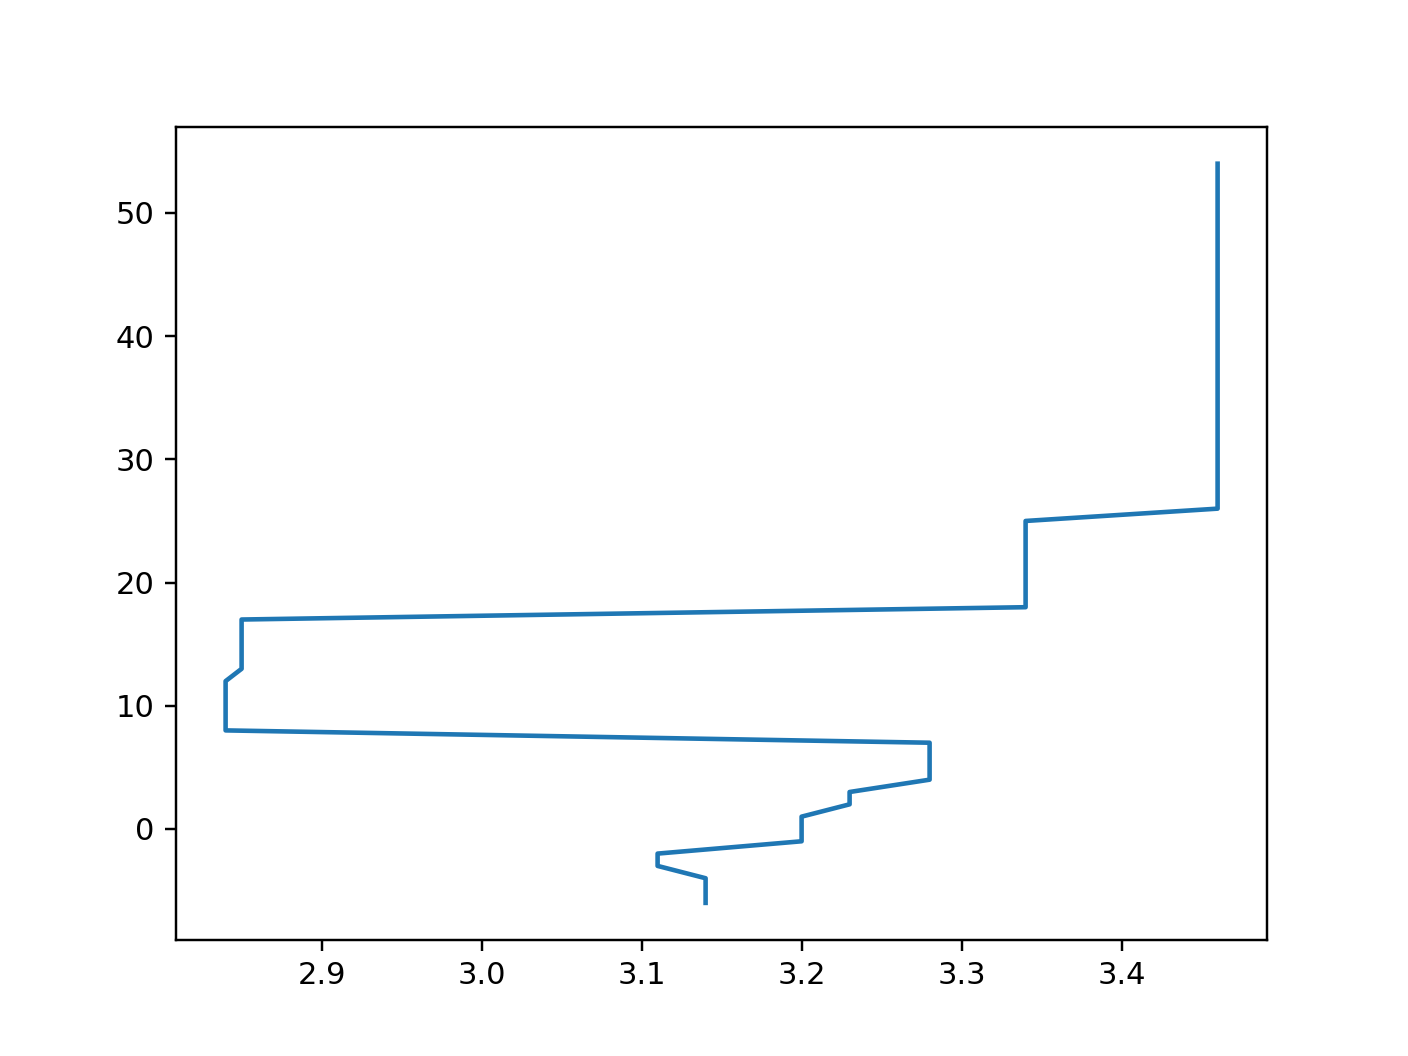

In [3]:
# Setup velocity grid:
# x,y,z labels in m:
# (Note: Use local NonLinLoc grid coords)
x_node_labels = np.arange(-60,60.5,1.) 
y_node_labels = np.arange(-60,60.5,1.) 
z_node_labels = np.arange(-6.0,54.5,1.) 
vel_grid = np.zeros((len(x_node_labels),len(y_node_labels),len(z_node_labels)))
# # vertical gradient
# a = 1.0e3
# vmax = 6.0e3
# b = (vmax-a)/np.max(z_node_labels)
# for n in range(z_node_labels.size):
#     vel_grid[:, :, n] = a + b*z_node_labels[n]
# vel_grid = vel_grid / 1000.
# # Homogeneous:
# vel_grid[:,:,:] = 4000. / 1000.
# 1D nonlinloc vel model:
# v_p = [5.44, 5.44, 5.40, 5.49, 5.47, 5.61, 4.87, 4.92, 5.86, 6.28, 6.28]
v_s = [3.14, 3.14, 3.11, 3.2, 3.23, 3.28, 2.84, 2.85, 3.34, 3.46, 3.46]
depths = [-6.5, -5.0, -2.5, 0.0, 2.5, 5.0, 10.0, 15.0, 20.0, 30.0, 100.0]
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx
for n in range(z_node_labels.size):
    val, nearest_idx = find_nearest(depths, z_node_labels[n])
    vel_grid[:, :, n] = v_s[nearest_idx]
plt.figure()
plt.plot(vel_grid[0, 0, :], z_node_labels)
plt.show()
    

In [5]:
# Perform ray tracing to get path lengths for all events:
perform_ray_tracing = False

# Load in magnitudes analysis data:
# (Note: Found using SeisSrcMoment)
mag_dict = pickle.load(open(moment_mags_dict_fname, 'rb'))

# Get all t* values, in order for event:
# (Note: order is really important, as ray path lengths and t* values must correspond to one another)
event_fnames = list(mag_dict.keys())

# Initialise ray tracing grid:
if perform_ray_tracing:
    try:
        del rays
        gc.collect()
    except:
        print('')
    rays = attnTomo.rays(x_node_labels, y_node_labels, z_node_labels, vel_grid)#, n_threads=8)

In [6]:
# Get source and receiver coords:
# Note: Use NonLinLoc local grid coords here, so make sure that
# the velocity grid above is correlated to these coordinates!)
if perform_ray_tracing:

    count=0
    for i in range(len(event_fnames)):
        event_fname=event_fnames[i]
        count+=1
        print('Processing ray paths for event:',count,'/',len(event_fnames))

        # Get source coords:
        nonlinloc_hyp_data = NonLinLocPy.read_nonlinloc.read_hyp_file(event_fname)
        src_coords = [[nonlinloc_hyp_data.max_prob_hypocenter['x'],
                         nonlinloc_hyp_data.max_prob_hypocenter['y'],
                         nonlinloc_hyp_data.max_prob_hypocenter['z']]]
        src_coords = np.array(src_coords) 

        # Get receiver coords, for specified seismic phase:
        rcv_coords = []
        stations = list(nonlinloc_hyp_data.phase_data.keys())
        for station in stations:
            # Check if current station t_star exists and is positive:
            try:
                t_star_curr = mag_dict[event_fname][station]['t_star']
            except KeyError:
                continue
            t_star_curr = mag_dict[event_fname][station]['t_star']
            Q_stdev_curr = mag_dict[event_fname][station]['Q_stdev']
            if t_star_curr > 0.:
                if Q_stdev_curr < Q_stdev_filt:
                    try:
                        station_coords_curr = []
                        for a in ['x','y','z']:
                            station_coords_curr.append(nonlinloc_hyp_data.phase_data[station][seismic_phase_to_use]['StaLoc'][a])
                        rcv_coords.append(station_coords_curr)
                    except KeyError:
                        continue
                else:
                    continue
            else:
                continue
        rcv_coords = np.array(rcv_coords)  

        # And add these to the overall ray paths:
        if len(rcv_coords) > 0 and len(src_coords) > 0:
            tic = time.clock()
            rays.add_event_rays(rcv_coords, src_coords)
            toc = time.clock()
            print('Time overall:', toc-tic)


In [7]:
# Save ray tracing output:
if perform_ray_tracing:
    rays.save_ray_info(out_fname='ray_info_S.pkl')
    # del rays
    # gc.collect()

In [55]:
# Load saved rays in:
f = open('ray_info_S.pkl', 'rb')
rays = pickle.load(f)

<IPython.core.display.Javascript object>


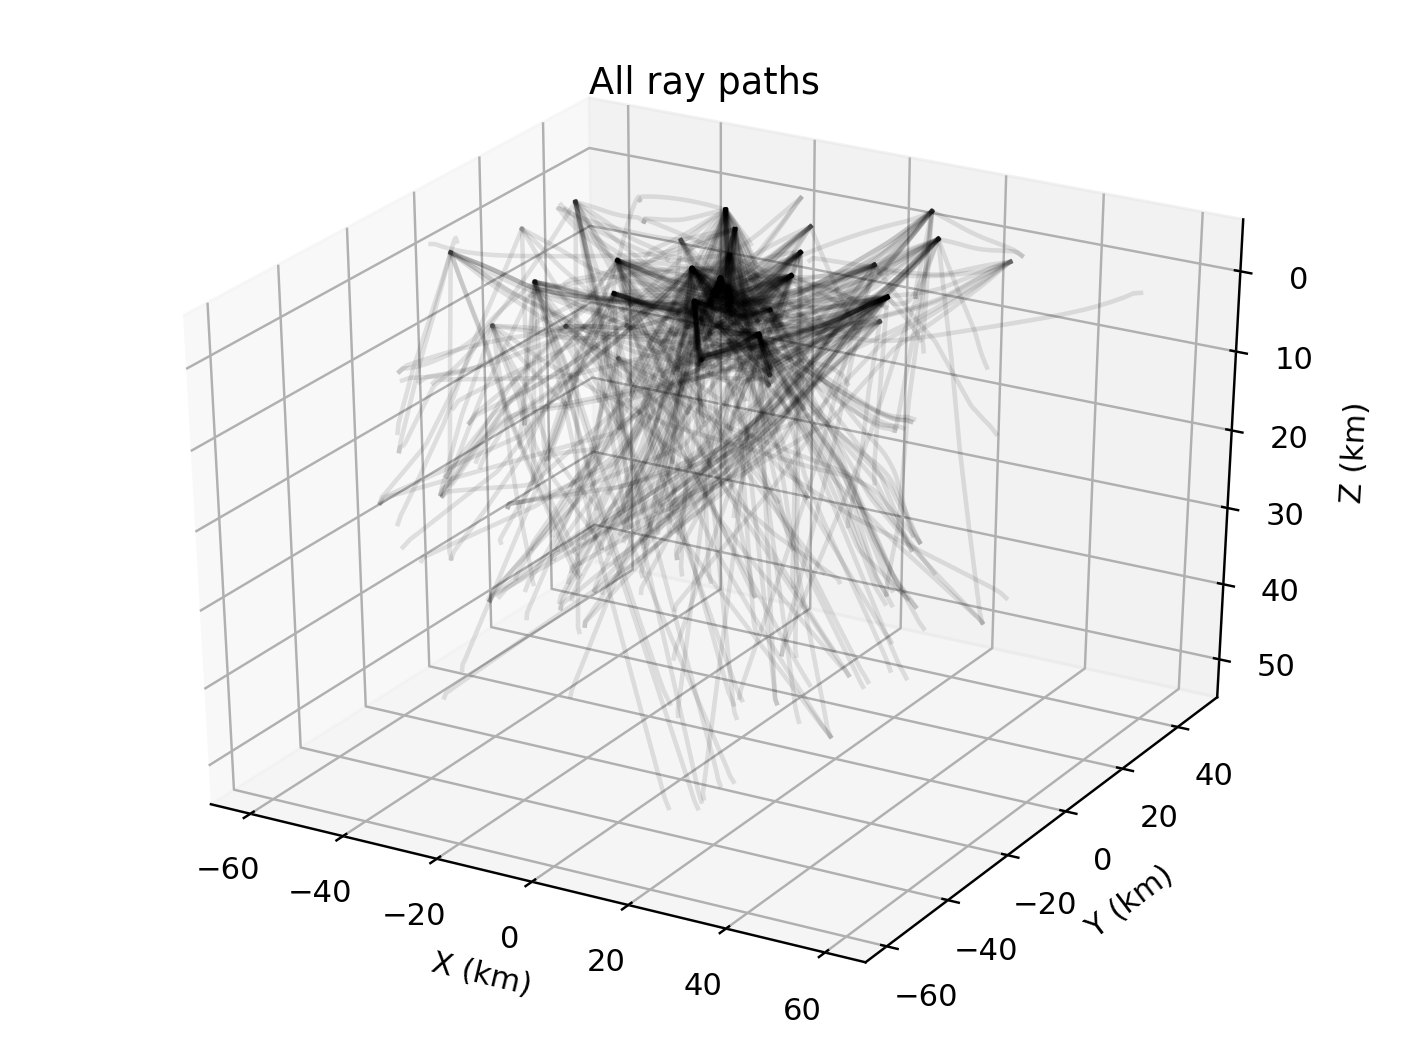

In [56]:
# Plot ray path results for checking:
plot_ray_path_checks_1=True

if plot_ray_path_checks_1:
#     # Plot example of path length calculations:
#     plt.figure()
#     plt.imshow(np.sum(rays.rays_cell_path_lengths_grids[5], axis=2))
#     plt.colorbar(label='Path length (m)')
#     plt.show()
    
    # And plot ray paths:
    rays.plot_all_ray_paths()

In [58]:
# Initiate the inversion object:
inv = attnTomo.inversion(rays)

In [59]:
# Prep rays for inversion (by finding ray path lengths and G, the tomography tensor):
inv.prep_rays_for_inversion()



Shape before consolidation: (756, 893101)
Consolidated arrays by removing non-sampled cells. 
 The info on these removed cells is held in: self.unsampled_cell_idxs.
Shape after consolidation: (756, 15999)
Finished data preparation for inversion


## Get t* data for inversion:

In [60]:
# Load in magnitudes analysis data:
inv.prep_t_stars_from_SeisSrcMoment_for_inversion(moment_mags_dict_fname, seismic_phase_to_use, Q_stdev_filt=Q_stdev_filt)


Number of t_star observations to use: 756


## Perform inversion:

In [61]:
# Specify damping:
lamb = 1. # Damping

# And perform inversion:
Q_tomo_array = inv.perform_inversion(lamb=lamb, Q_init=250., result_out_fname='tmp_inv_result.pkl')

 
LSQR            Least-squares solution of  Ax = b
The matrix A has      756 rows  and    15999 cols
damp = 1.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =    31998
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  4.00000e-03   5.486e-01  5.486e-01    1.0e+00  3.5e+00
     1  4.42886e-03   3.797e-01  3.980e-01    3.7e-01  5.1e-01   2.8e+00  1.0e+00
     2  4.71604e-03   3.032e-01  3.470e-01    3.2e-01  2.1e-01   4.3e+00  2.3e+00
     3  4.86036e-03   2.556e-01  3.251e-01    3.0e-01  1.0e-01   5.3e+00  3.7e+00
     4  4.84213e-03   2.371e-01  3.199e-01    3.0e-01  5.2e-02   6.2e+00  5.0e+00
     5  4.77108e-03   2.250e-01  3.174e-01    2.9e-01  2.4e-02   6.9e+00  6.5e+00
     6  4.73299e-03   2.202e-01  3.166e-01    2.9e-01  1.4e-02   7.5e+00  7.9e+00
     7  4.72937e-03   2.181e-01  3.164e-01    2.9e-01  8.2e-03   8.1e+00  9.4e+00
     8  4.73763e-03   2.171e

## Run a number of inversions for differnet regularisation, and choose optimal result:

In [62]:
# Perform L-curve analysis:
# Note: By varying the damping coefficient, lambda, and plotting the curve.

# Spcify data processing switches:
find_various_lambda_results = False

if find_various_lambda_results:
    inv.perform_multi_lambda_reg_inversion(lambs=[1., 0.1, 1e-2, 1e-3, 1e-4], Q_init=250., results_out_fname_prefix='result_lsqr_lamb_')



In [63]:
# Save inversion result:
inv.save_inversion_obj(out_fname='inv_info.pkl')

Saved class object to file:  inv_info.pkl
(Note: To load, load using pickle as rb)


## Plot optimal inversion result:

In [78]:
# Create inv plot object:
inv.lambs = [1., 0.1, 1e-2, 1e-3, 1e-4]
inv.results_out_fname_prefix = 'result_lsqr_lamb_'
inv_plot = attnTomo.plot(rays, inv)

<IPython.core.display.Javascript object>


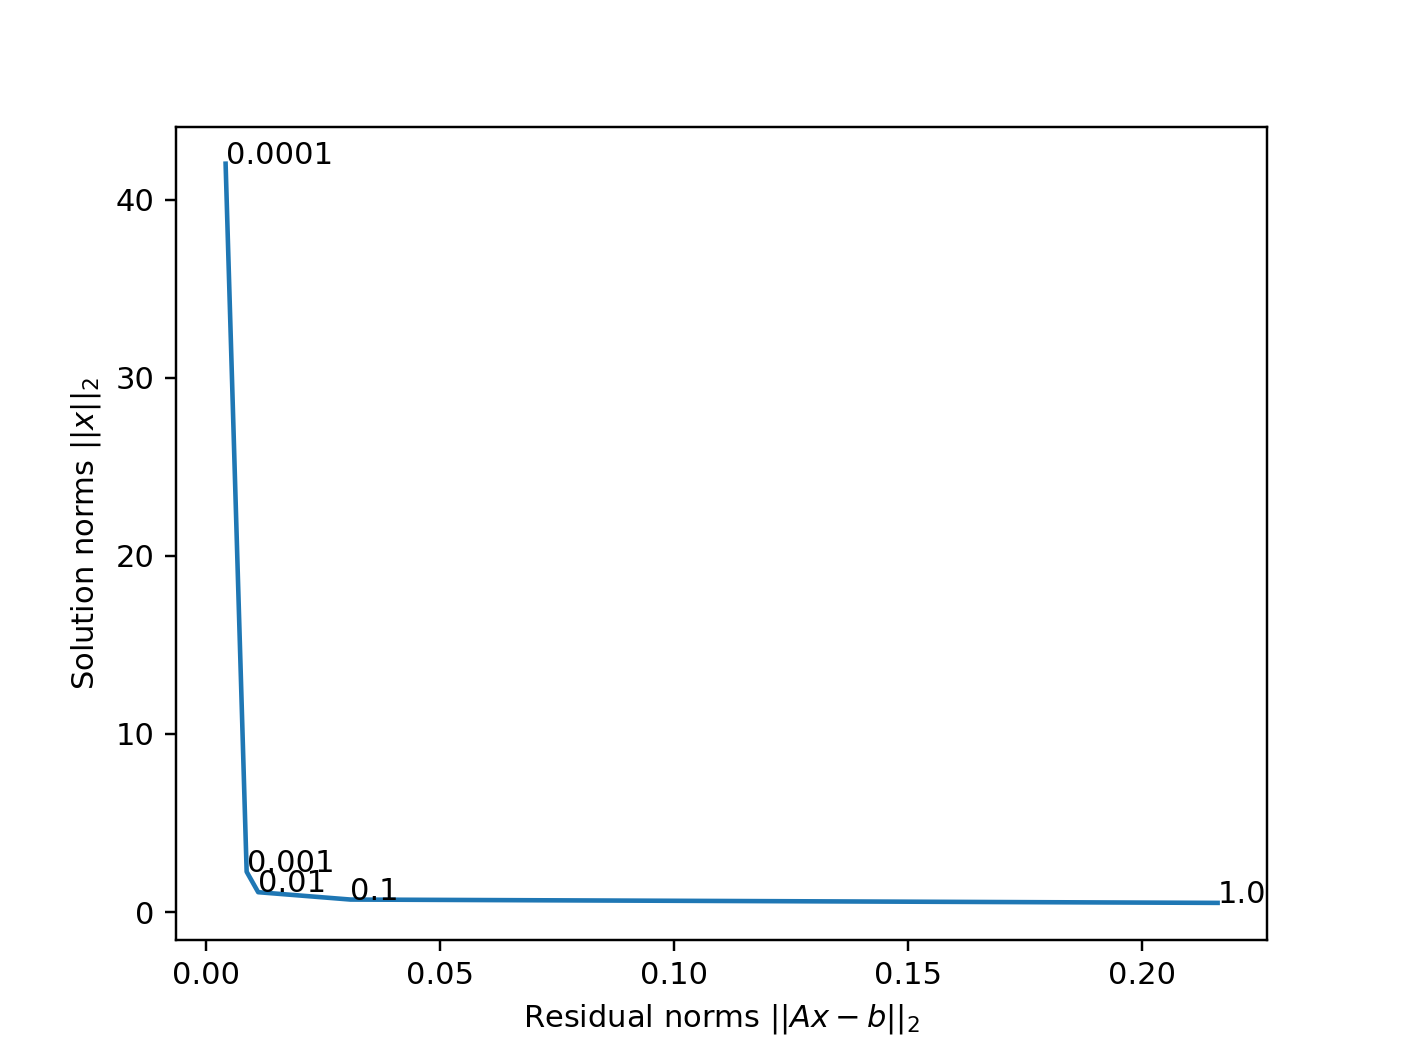

In [79]:
# Plot L-curve to find optimal damping/regularisation coefficient:
inv_plot.plot_L_curve()

In [80]:
# Specify optimal lambda, from L-curve analysis:
opt_lamb = 0.01

Saved interpolated data to:  opt_Q_tomo_array_interp_S


<IPython.core.display.Javascript object>


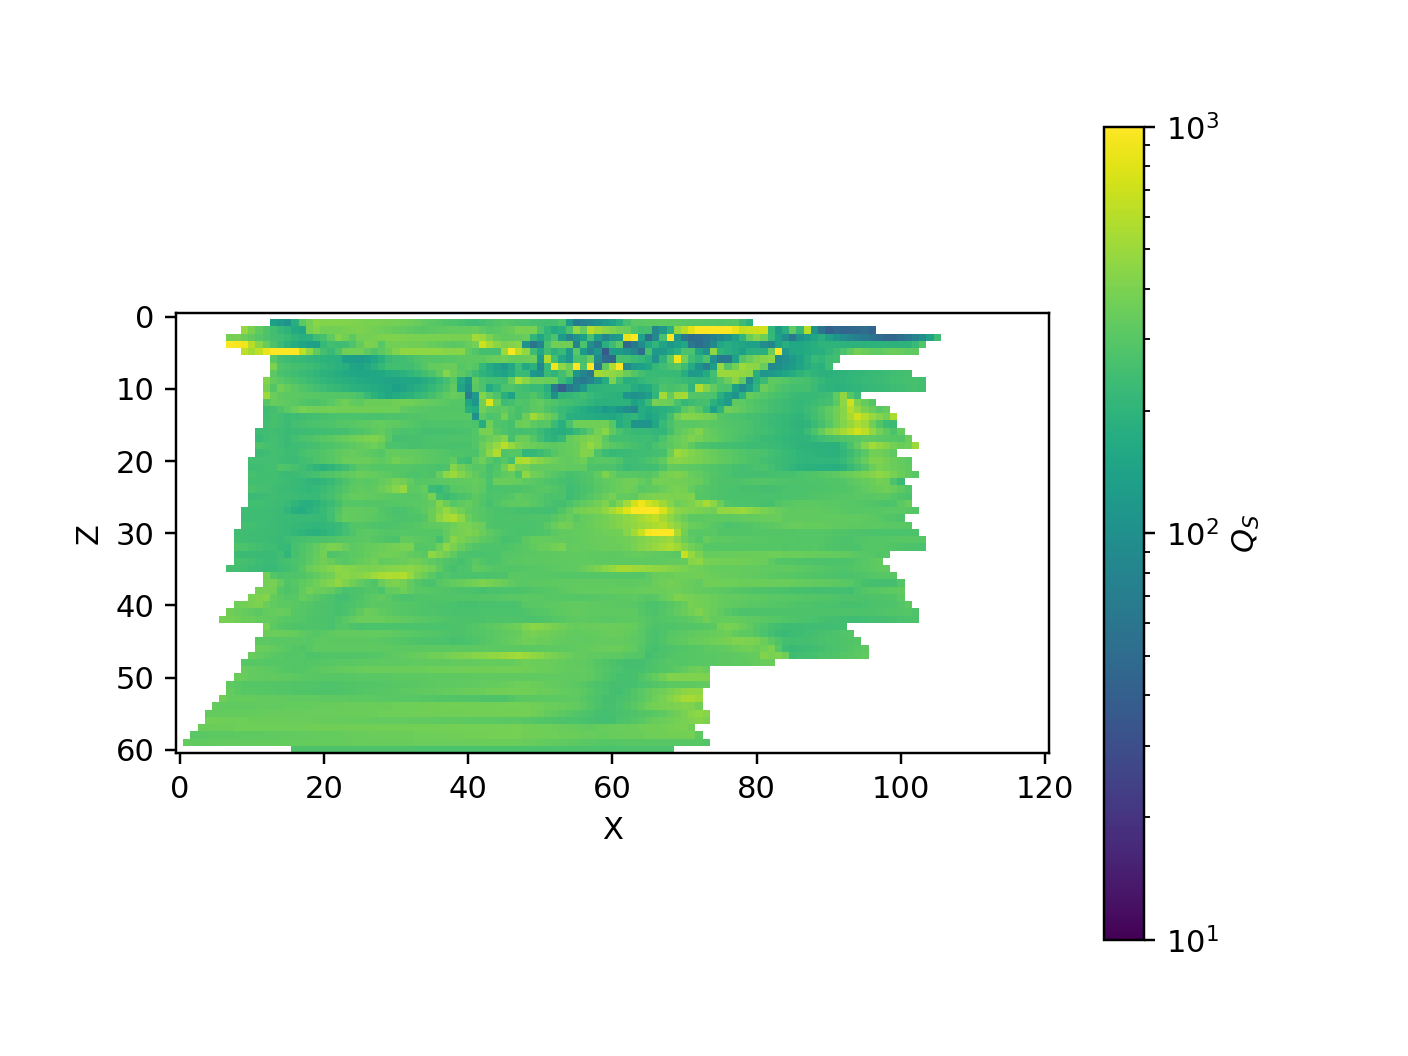

/Users/eart0504/Documents/projects/Uturuncu/attn_tomo/python_attn_tomo_Uturuncu/scripts/attnTomo.py:510: RuntimeWarning: divide by zero encountered in true_divide
  elif plane == 'yz':


In [83]:
# Plot optimal inversion result:
inv_plot.plot_inversion_result(opt_lamb, plane='xz', plane_idx=60)